# Imports

In [101]:
import pandas as pd
import numpy as np
import polars as pl
from polars import StringCache
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import lightgbm as lgb

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

# Import helper functions
from src.data_preprocessing.cleaner import PolarsLoader

In [102]:
DATA_PATH = os.path.join(ROOT, "data")
CLEAN_DATA_PATH = os.path.join(DATA_PATH, "proccessed_data")

TRAIN_FILE = os.path.join(DATA_PATH, "train_data.csv")
TEST_FILE = os.path.join(DATA_PATH, "test_data.csv") 

# Data Loading

In [103]:
pp = PolarsLoader(sampling=True)
pl_train, CAT_COLS, NUM_COLS = pp.initial_preprocessing(TRAIN_FILE)
pl_test, _, _ = pp.initial_preprocessing(TEST_FILE)

FEATURES = CAT_COLS + NUM_COLS
TARGET = 'target'

#Print data information
print(f"Train data shape: {pl_train.shape}")
print(f"Test data shape: {pl_test.shape}")

print(f"Number of categorical columns: {len(CAT_COLS)}")
print(f"Number of numerical columns: {len(NUM_COLS)}")
print(f"% target distribution in train data: {pl_train['target'].value_counts(normalize=True)}")

print("*"*50)
print("DATASET IS HIGHLY IMBALANCED")
print("*"*50)

Train data shape: (1000000, 18)
Test data shape: (1000000, 18)
Number of categorical columns: 10
Number of numerical columns: 7
% target distribution in train data: shape: (2, 2)
┌────────┬────────────┐
│ target ┆ proportion │
│ ---    ┆ ---        │
│ i16    ┆ f64        │
╞════════╪════════════╡
│ 1      ┆ 0.028379   │
│ 0      ┆ 0.971621   │
└────────┴────────────┘
**************************************************
DATASET IS HIGHLY IMBALANCED
**************************************************


In [104]:
category_encoder = OrdinalEncoder(
        categories='auto', dtype=np.int16, 
        handle_unknown='use_encoded_value', 
        unknown_value=-2, encoded_missing_value=-1
    )

# Fit and transform the category columns
train_data_encoded = category_encoder.fit_transform(pl_train.select(CAT_COLS))

# Assign the transformed categories back to the Polars DataFrame
encoded_columns = [
    pl.Series(cat_col, train_data_encoded[:, c]) 
    for c, cat_col in enumerate(CAT_COLS)
]

pl_train = pl_train.with_columns(encoded_columns)

In [105]:
# Transform the test data with the same encoder
test_data_encoded = category_encoder.transform(pl_test.select(CAT_COLS))

# Assign the transformed categories back to the Polars test DataFrame
encoded_test_columns = [
    pl.Series(cat_col, test_data_encoded[:, c]) 
    for c, cat_col in enumerate(CAT_COLS)
]

pl_test = pl_test.with_columns(encoded_test_columns)

In [106]:
# Cast all the CAT_COLS back to categorical in both pl_train and pl_test
pl_train = pl_train.with_columns([
    pl.col(col).cast(pl.String).cast(pl.Categorical) for col in CAT_COLS
])

pl_test = pl_test.with_columns([
    pl.col(col).cast(pl.String).cast(pl.Categorical) for col in CAT_COLS
])

# Baseline LightGBM model training

In [107]:
def downsample_data_pl(df: pl.DataFrame, neg_ratio: float = None, is_train: bool = True) -> pl.DataFrame:
        
    if is_train:
        # Extract the counts of positive and negative cases
        p_cases = df.filter(pl.col('target') == 1)
        n_cases = df.filter(pl.col('target') == 0)

        # If neg_ratio is None use all negative samples
        if neg_ratio is not None:
            N = int(p_cases.height * neg_ratio)
            n_cases = n_cases.sample(n=N, seed=23)
        
        # Concatenar los casos negativos y positivos
        df = pl.concat([n_cases, p_cases])
        
    return df

In [108]:
print(pl_train.shape)
print(f"Original target distribution: {pl_train['target'].value_counts(normalize=True)}")

pl_train_down = downsample_data_pl(pl_train, neg_ratio=10, is_train=True)

print("*"*50)
print(pl_train_down.shape)
print(f"New target distribution: {pl_train_down['target'].value_counts(normalize=True)}")

(1000000, 18)
Original target distribution: shape: (2, 2)
┌────────┬────────────┐
│ target ┆ proportion │
│ ---    ┆ ---        │
│ i16    ┆ f64        │
╞════════╪════════════╡
│ 1      ┆ 0.028379   │
│ 0      ┆ 0.971621   │
└────────┴────────────┘
**************************************************
(312169, 18)
New target distribution: shape: (2, 2)
┌────────┬────────────┐
│ target ┆ proportion │
│ ---    ┆ ---        │
│ i16    ┆ f64        │
╞════════╪════════════╡
│ 1      ┆ 0.090909   │
│ 0      ┆ 0.909091   │
└────────┴────────────┘


In [109]:
train = pl_train.to_pandas()
test = pl_test.to_pandas()

# Crossvalidation

In [110]:
lgb_params = {
    'objective': 'binary',
    'metric': 'f1',
    'verbose': -1
}

In [111]:
from sklearn.model_selection import cross_validate

X = train[FEATURES]
y = train[TARGET]

model = lgb.LGBMClassifier(**lgb_params)

cv = KFold(5, shuffle=True, random_state=23)

results = cross_validate(
    estimator=model,
    X=X, y=y,
    cv=cv,
    scoring='f1',
    return_train_score=True
)

# Print F1 scores for both train and validation
print(f"Folds Train F1 scores: {results['train_score']}")
print(f"Folds Validation F1 scores: {results['test_score']}")

# Print mean F1 scores
print("*"*50)
print(f"Mean Train F1 score: {np.mean(results['train_score'])}")
print(f"Mean Validation F1 score: {np.mean(results['test_score'])}")

Folds Train F1 scores: [0.47903345 0.47619615 0.47287701 0.47875438 0.47329749]
Folds Validation F1 scores: [0.46306716 0.45584385 0.45642365 0.44658325 0.4631678 ]
**************************************************
Mean Train F1 score: 0.47603169553239316
Mean Validation F1 score: 0.45701714357167383


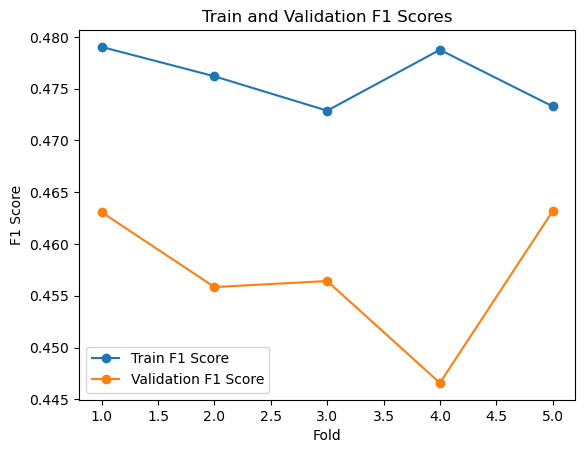

In [112]:
# Get train and validation F1 scores
train_scores = results['train_score']
valid_scores = results['test_score']

# Plot
plt.plot(range(1, len(train_scores) + 1), train_scores, marker='o', label='Train F1 Score', linestyle='-')
plt.plot(range(1, len(valid_scores) + 1), valid_scores, marker='o', label='Validation F1 Score', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train and Validation F1 Scores')
plt.legend()
plt.show()

# Train and predict

In [113]:
BENCHMARK = 0.503

model.fit(X, y)

predictions = model.predict(test[FEATURES])
test_f1 = f1_score(test[TARGET], predictions)

F1 on test data: 0.5638422227567551
Improvement over Benchmark: 0.060842222756755104


In [114]:
print(f"F1 on test data: {test_f1}")
print(f"Improvement over Benchmark: {round(100*((test_f1/BENCHMARK)-1),2)}%")

F1 on test data: 0.5638422227567551
Improvement over Benchmark: 12.1%
